In [21]:
import numpy as np
import random
import matplotlib.pyplot as plt

# -----------------------
# Simulation Parameters
# -----------------------
N = 30              # Total number of sensors
M = 1               # Number of sensors pulled per time step (for Optimal & WIQL)
T_steps = 10000     # Total simulation time steps
threshold = 0.5     # Threshold for significant change
pull_penalty = 0.3  # Penalty for pulling a sensor
initial_value = 20  # Initial value for each sensor (for raw measurements)
max_delay = 50      # Maximum delay value to track
max_rate = 0.1      # Maximum rate of change (20% change per step)


In [20]:
def update_node_state_dewma(measured_value, last_state_value, last_rate_of_change, delta_t=1, beta_1=0.9, beta_2=0.9):
    """
    DEWMA update for node state

    Args:
    - measured_value: Current measurement
    - last_state_value: Previous state value
    - last_rate_of_change: Previous rate of change
    - delta_t: Time difference (default: 1)
    - beta_1, beta_2: DEWMA parameters

    Returns:
    - (new_state_value, new_rate_of_change)
    """
    x1 = beta_1 * measured_value + (1 - beta_1) * (last_state_value + last_rate_of_change * delta_t)
    x2 = beta_2 * ((x1 - last_state_value) / delta_t) + (1 - beta_2) * last_rate_of_change
    return (x1, x2)

# -----------------------
# State Representation
# -----------------------
def compute_state(rate, delay):
    """Compute continuous state as product of rate and delay"""
    return abs(rate) * delay

def discretize_state(x):
    """Discretize continuous state into bins"""
    bin_edges = np.linspace(0, max_rate * max_delay, 30)
    return np.digitize(x, bin_edges)

# -----------------------
# State Transitions
# -----------------------
def passive_transition(d):
    """State transition for passive action (not pulled)"""
    return min(d + 1, max_delay)

def active_transition(d):
    """State transition for active action (pulled)"""
    # 90% chance to reset delay, 10% chance to increase
    return 1 if random.random() < 0.9 else min(d + 1, max_delay)


Transmission Count by Category:
Category A: 1783 times
Category B: 3853 times
Category C: 14364 times


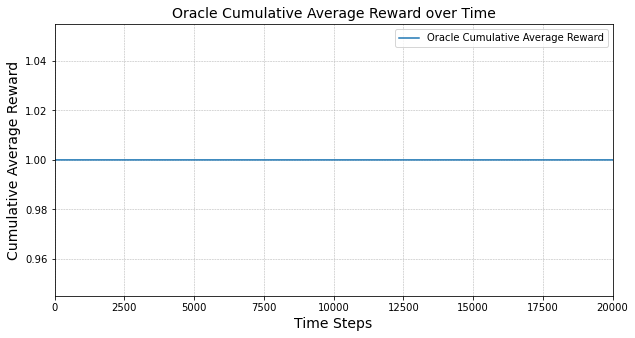

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load dataset
pivot_df = pd.read_csv("synthetic_scenario_30_nodes.csv")
pivot_df = pivot_df.apply(lambda x: x.fillna(x.mean()), axis=0)  # Fill missing values
pivot_df = pivot_df.head(20000)  # Restrict to first 20000 time steps

# Parameters
reward = 1
M = 1  # Maximum number of nodes that can be polled
theta = 0.5  # Threshold for reward condition
penalty = -0.5  # Penalty for polling when difference is <= theta
aoii_penalty = 0.5
initial_value = 20  # Initial estimate for last polled values

# Extract column names, ensuring "SN" is excluded
columns = [col for col in pivot_df.columns if col != "SN"]
num_nodes = len(columns)  # Number of sensor nodes based on dataset columns
num_time_steps = len(pivot_df)  # Total time steps based on dataset length

# Track the number of times each category is pulled
category_counts = {'Category A': 0, 'Category B': 0, 'Category C': 0}

# Initialize last polled values for each mote
last_polled_values = {col: initial_value for col in columns}

# Function to extract numeric node ID from column names dynamically
def extract_node_id(col_name):
    """Extract numeric node ID from column name, handling cases where no digits are found."""
    digits = ''.join(filter(str.isdigit, col_name))
    return int(digits) if digits else None  # Return None if no digits are found

# Oracle policy simulation function
def run_oracle_simulation(M):
    last_update_times = {col: 0 for col in columns}  # Initialize last update times
    cumulative_reward = 0  # Total cumulative reward
    cumulative_rewards = []  # Store cumulative average reward over time
    valuable_sensor_data = []

    for t in range(len(pivot_df)):  # Loop over each time step
        current_time_step = t
        diffs = {}

        # Calculate rewards for each mote
        for mote in columns:
            current_value = pivot_df.loc[current_time_step, mote]
            last_value = last_polled_values[mote]

            # Reward is the difference between the current and last value
            diffs[mote] = abs(current_value - last_value)

        # Filter nodes with rewards greater than the threshold
        eligible_nodes = {mote: diff for mote, diff in diffs.items() if diff > theta}

        # Select the top M nodes among eligible nodes
        top_m_nodes = sorted(eligible_nodes, key=eligible_nodes.get, reverse=True)[:M]

        total_reward_for_round = 0

        # Process the selected nodes
        for mote in top_m_nodes:
            measured_value = pivot_df.loc[current_time_step, mote]
            last_value = last_polled_values[mote]

            # Calculate reward
            total_reward_for_round += reward  # Reward (since all polled nodes have value > theta)

            # Update last polled value and time
            last_update_times[mote] = current_time_step
            last_polled_values[mote] = measured_value

            # Extract node ID dynamically and categorize
            node_id = extract_node_id(mote)
            if node_id is not None:
                if 1 <= node_id <= 10:
                    category_counts['Category A'] += 1
                elif 11 <= node_id <= 20:
                    category_counts['Category B'] += 1
                elif 21 <= node_id <= 30:
                    category_counts['Category C'] += 1

            # Store valuable sensor data
            valuable_sensor_data.append({
                'index': current_time_step,
                'selected_moteid': mote,
                'temperature': measured_value,
                'predicted_temperature': measured_value,  # Oracle knows the true value
                'time_elapsed': current_time_step - last_update_times[mote]
            })

        # Update cumulative reward
        cumulative_reward += total_reward_for_round
        cumulative_rewards.append(cumulative_reward / (t + 1))  # Compute cumulative average reward

    valuable_sensor_df = pd.DataFrame(valuable_sensor_data)
    return cumulative_rewards, valuable_sensor_df, category_counts

# Run the simulation for the given value of M
cumulative_rewards_oracle, valuable_sensor_df, category_pulled_counts = run_oracle_simulation(M)

# Print the number of times each category was pulled
print("Transmission Count by Category:")
for category, count in category_pulled_counts.items():
    print(f"{category}: {count} times")

# Save cumulative rewards to CSV
# Save cumulative rewards to CSV
pd.DataFrame(cumulative_rewards_oracle, columns=["cumulative_reward"]).to_csv("cumulative_rewards_oracle_final_2.csv", index=False)

# Save valuable sensor data to CSV
valuable_sensor_df.to_csv("valuable_sensor_data_oracle.csv", index=False)


# Plot cumulative average reward over time for Oracle
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(cumulative_rewards_oracle) + 1), cumulative_rewards_oracle, label='Oracle Cumulative Average Reward')
plt.xlabel('Time Steps', fontsize=14)
plt.ylabel('Cumulative Average Reward', fontsize=14)
plt.title('Oracle Cumulative Average Reward over Time', fontsize=14)
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xlim(0, len(cumulative_rewards_oracle))

# Save the plot
plt.savefig("oracle_cumulative_average_reward_final.png")

plt.show()



Transmission Count by Category:
Category A: 66655 times
Category B: 66700 times
Category C: 66645 times


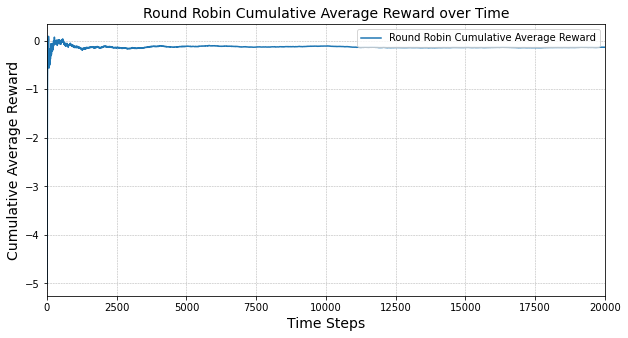

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load dataset and preprocess
pivot_df = pd.read_csv("synthetic_scenario_30_nodes.csv")
pivot_df = pivot_df.apply(lambda x: x.fillna(x.mean()), axis=0)  # Fill missing values
pivot_df = pivot_df.head(20000)  # Restrict to first 20000 time steps

# Parameters
reward = 1
M = 10  # Maximum number of nodes that can be polled
theta = 0.5  # Threshold for significant difference
penalty = -0.5  # Penalty for insignificant difference
initial_value = 20  # Initial value for last polled
num_nodes = 30  # Total number of sensor nodes based on dataset
num_time_steps = len(pivot_df)  # Total time steps in the dataset

# Extract column names, ensuring "SN" is excluded
columns = [col for col in pivot_df.columns if col != "SN"]

# Track the number of times each category is pulled
category_counts = {'Category A': 0, 'Category B': 0, 'Category C': 0}

# Initialize last polled values
last_polled_values_rr = {column: initial_value for column in columns}

# Function to extract numeric node ID from column names dynamically
def extract_node_id(col_name):
    """Extract numeric node ID from column name, handling cases where no digits are found."""
    digits = ''.join(filter(str.isdigit, col_name))
    return int(digits) if digits else None  # Return None if no digits are found

# Round Robin simulation function with transmission count tracking
def run_simulation_round_robin(pivot_df, columns, M, theta, penalty):
    last_polled_values = {column: initial_value for column in columns}  # Last polled values
    cumulative_reward = 0  # Total cumulative reward
    cumulative_rewards = []  # Store cumulative rewards over time

    for t in range(len(pivot_df)):  # Loop over all time steps
        # Poll M nodes in cyclic order
        nodes_rr = [columns[(t + i) % num_nodes] for i in range(M)]  # Poll M nodes in cyclic order
        round_reward = 0  # Reward for the current time step

        for node_rr in nodes_rr:
            current_value = pivot_df.loc[t, node_rr]  # Current value for the node
            last_value = last_polled_values[node_rr]

            # Calculate reward or penalty
            if abs(current_value - last_value) > theta:
                round_reward += reward  # Reward
            else:
                round_reward += penalty  # Penalty

            # Update the last polled value
            last_polled_values[node_rr] = current_value

            # Extract node ID dynamically and categorize
            node_id = extract_node_id(node_rr)
            if node_id is not None:
                if 1 <= node_id <= 10:
                    category_counts['Category A'] += 1
                elif 11 <= node_id <= 20:
                    category_counts['Category B'] += 1
                elif 21 <= node_id <= 30:
                    category_counts['Category C'] += 1

        # Update cumulative reward
        cumulative_reward += round_reward
        cumulative_rewards.append(cumulative_reward / (t + 1))  # Append cumulative average reward

    return cumulative_rewards, category_counts

# Run Round Robin simulation with transmission count tracking
cumulative_rewards_rr, category_pulled_counts = run_simulation_round_robin(pivot_df, columns, M, theta, penalty)

# Print the number of times each category was pulled
print("Transmission Count by Category:")
for category, count in category_pulled_counts.items():
    print(f"{category}: {count} times")

# Save cumulative rewards to CSV
pd.DataFrame(cumulative_rewards_rr, columns=["cumulative_reward"]).to_csv("cumulative_rewards_round_robin_final.csv", index=False)

# Plot cumulative average reward over time
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(cumulative_rewards_rr) + 1), cumulative_rewards_rr, label='Round Robin Cumulative Average Reward')
plt.xlabel('Time Steps', fontsize=14)
plt.ylabel('Cumulative Average Reward', fontsize=14)
plt.title('Round Robin Cumulative Average Reward over Time', fontsize=14)
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xlim(0, len(cumulative_rewards_rr))

# Save the plot
plt.savefig("round_robin_cumulative_average_reward_final.png")

plt.show()


Transmission Count by Category:
Category A: 6671 times
Category B: 6669 times
Category C: 6660 times


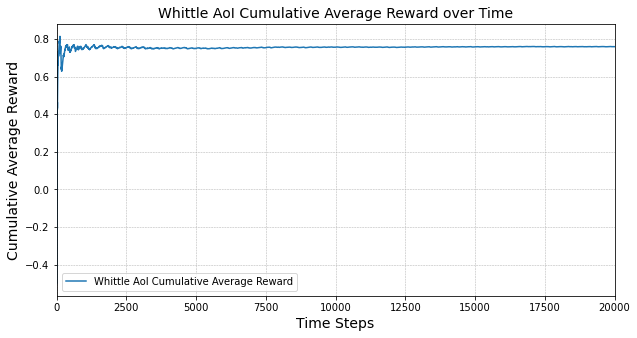

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load dataset and preprocess
pivot_df = pd.read_csv("synthetic_scenario_30_nodes.csv")
pivot_df = pivot_df.apply(lambda x: x.fillna(x.mean()), axis=0)  # Fill missing values
pivot_df = pivot_df.head(20000)  # Restrict to first 20000 time steps

# Parameters
reward = 1
M = 1  # Number of nodes to poll
theta = 0.5  # Threshold for node transmission
penalty = -0.5  # Penalty for polling when the condition is not met
num_nodes = len([col for col in pivot_df.columns if col != "SN"])  # Total number of sensor nodes
num_time_steps = len(pivot_df)  # Total time steps in the dataset

# Extract column names, ensuring "SN" is excluded
columns = [col for col in pivot_df.columns if col != "SN"]

# Track the number of times each category is pulled
category_counts = {'Category A': 0, 'Category B': 0, 'Category C': 0}

# Initialize last polled values
last_polled_values_whittle = {col: 20.0 for col in columns}  # Initial values

# Function to extract numeric node ID from column names dynamically
def extract_node_id(col_name):
    """Extract numeric node ID from column name, handling cases where no digits are found."""
    digits = ''.join(filter(str.isdigit, col_name))
    return int(digits) if digits else None  # Return None if no digits are found

# Whittle Index-based AoI simulation function with transmission count tracking
def run_simulation_whittle_aoi(pivot_df, num_nodes, M, theta, penalty):
    """Simulate Whittle Index-based polling strategy for AoI with transmission count tracking."""
    cumulative_reward = 0
    cumulative_rewards = []
    last_update_whittle = np.zeros(num_nodes)  # Track last update times
    last_polled_values = {col: 20.0 for col in pivot_df.columns}  # Initialize last polled values

    for t in range(len(pivot_df)):  # Iterate over all time steps
        whittle_indices = {}

        # Compute Whittle indices for each node
        for node in range(num_nodes):  # Now using 0-based index
            column_name = pivot_df.columns[node]  # Get column directly
            
            delta_t_dynamic = t - last_update_whittle[node]  # Time since last update
            current_aoi = delta_t_dynamic
            future_aoi_passive = delta_t_dynamic + penalty
            future_aoi_active = 0  # Assuming perfect transmission

            q_passive = current_aoi + future_aoi_passive
            q_active = current_aoi + future_aoi_active + penalty  # No additional penalty for active action
            whittle_indices[node] = q_passive - q_active

        # Step 2: Select top M nodes
        nodes_to_poll = [node for node, index in whittle_indices.items() if index >= 0]
        if len(nodes_to_poll) > M:
            nodes_to_poll = sorted(nodes_to_poll, key=lambda node: whittle_indices[node], reverse=True)[:M]

        round_reward = 0  # Reward for the current time step

        # Step 3: Poll selected nodes
        for node in nodes_to_poll:
            column_name = pivot_df.columns[node]  # Get the column name
            
            current_value = pivot_df.loc[t, column_name]
            last_value = last_polled_values[column_name]

            # Calculate reward or penalty
            if abs(current_value - last_value) > theta:
                round_reward += reward  # Reward
            else:
                round_reward += penalty  # Penalty

            # Update last polled values
            last_polled_values[column_name] = current_value
            last_update_whittle[node] = t  # Update last update time

            # Extract node ID dynamically and categorize
            node_id = extract_node_id(column_name)
            if node_id is not None:
                if 1 <= node_id <= 10:
                    category_counts['Category A'] += 1
                elif 11 <= node_id <= 20:
                    category_counts['Category B'] += 1
                elif 21 <= node_id <= 30:
                    category_counts['Category C'] += 1

        # Update cumulative reward
        cumulative_reward += round_reward
        cumulative_rewards.append(cumulative_reward / (t + 1))  # Compute cumulative average reward

    return cumulative_rewards, category_counts

# Run the simulation with transmission count tracking
cumulative_rewards_whittle, category_pulled_counts = run_simulation_whittle_aoi(pivot_df, num_nodes, M, theta, penalty)

# Print the number of times each category was pulled
print("Transmission Count by Category:")
for category, count in category_pulled_counts.items():
    print(f"{category}: {count} times")

# Save cumulative rewards to CSV
pd.DataFrame(cumulative_rewards_whittle, columns=["cumulative_reward"]).to_csv("cumulative_rewards_whittle_aoi_final.csv", index=False)

# Plot cumulative average reward over time
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(cumulative_rewards_whittle) + 1), cumulative_rewards_whittle, label='Whittle AoI Cumulative Average Reward')
plt.xlabel('Time Steps', fontsize=14)
plt.ylabel('Cumulative Average Reward', fontsize=14)
plt.title('Whittle AoI Cumulative Average Reward over Time', fontsize=14)
plt.legend()
plt.grid(True, linestyle="--", linewidth=0.5)
plt.xlim(0, len(cumulative_rewards_whittle))

# Save the plot
plt.savefig("whittle_aoi_cumulative_average_reward_final.png")
plt.show()


In [25]:
def get_reward(current_value, last_value, threshold=0.5):
    """
    Get reward based on difference between current and last known value

    Args:
    - current_value: Current sensor value
    - last_value: Last known value (from last time the sensor was pulled)
    - threshold: Threshold value to exceed
    - apply_penalty: Whether to apply the pulling penalty (default: True)

    Returns:
    - Reward value (1 - penalty if difference > threshold, otherwise 0 - penalty)
    """
    if abs(current_value - last_value) > threshold:
        return 1
    return -0.5

Transmission Count by Category:
Category A: 55 times
Category B: 59 times
Category C: 63 times


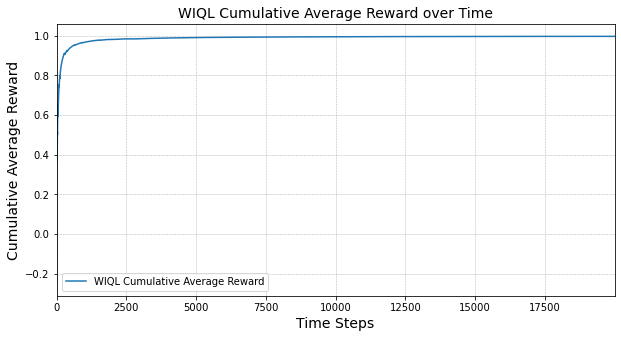

In [28]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt

def run_simulation_WIQL(pivot_df, M, threshold):
    """
    Simulate the Whittle Index Q-Learning policy using actual sensor data.

    Args:
    - sensor_df (pd.DataFrame): DataFrame containing temperature values for each sensor over time.
    - M (int): Number of sensors to poll per step.
    - threshold (float): Reward threshold.

    Returns:
    - Cumulative average rewards list
    - Category count dictionary
    """

    N = len(pivot_df.columns)  # Number of sensors
    T_steps = len(pivot_df)  # Number of time steps

    # Initialize delays for all sensors
    delays = np.ones(N, dtype=int)

    # Initialize rewards history
    cumulative_reward = 0
    cumulative_rewards = []

    # Track activations by category
    category_counts = {'Category A': 0, 'Category B': 0, 'Category C': 0}

    # Node estimates (at sensor) and sink estimates (last pulled values) as tuples (x1, x2)
    node_estimates = [(20.0, 0) for _ in range(N)]  # Initial estimate (20.0)
    sink_estimates = [(20.0, 0) for _ in range(N)]

    # Last known raw values (for reward calculation)
    last_values = np.ones(N) * 20.0  # Initial values

    # Initialize Q-values and visit counts
    max_state = 30  # Number of discrete states
    Q = [{s: {0: 0.0, 1: 0.0} for s in range(1, max_state+1)} for _ in range(N)]
    counts = [{s: {0: 0, 1: 0} for s in range(1, max_state+1)} for _ in range(N)]

    for t in range(1, T_steps):
        # Get current values for all sensors from `sensor_df`
        current_values = pivot_df.iloc[t].values  # Extract values directly from dataframe

        # Update node estimates using DEWMA
        for i in range(N):
            node_estimates[i] = update_node_state_dewma(
                current_values[i],
                node_estimates[i][0],
                node_estimates[i][1])

        # Sensor selection (epsilon-greedy based on Whittle indices)
        eps = N / (N + t)  # Decaying epsilon for exploration

        if random.random() < eps:
            # Random exploration
            active_sensors = random.sample(range(N), M)
        else:
            # Exploitation based on Whittle indices
            whittle_indices = np.zeros(N)
            for i in range(N):
                state_val = compute_state(sink_estimates[i][1], delays[i])
                discrete_state = discretize_state(state_val)
                whittle_indices[i] = Q[i][discrete_state][1] - Q[i][discrete_state][0]

            # Select top M sensors by Whittle index
            active_sensors = list(np.argsort(whittle_indices)[-M:])

        # Convert to action vector (1 for active, 0 for passive)
        actions = [1 if i in active_sensors else 0 for i in range(N)]

        # Calculate step reward
        round_reward = 0
        unique_pulled_categories = set()  # Track unique sensors polled in this step

        for i in active_sensors:
            # Get reward based on difference from last known value
            reward = get_reward(current_values[i], last_values[i], threshold)
            round_reward += reward

            # Track category counts
            node_id = extract_node_id(pivot_df.columns[i])  # Extract node ID
            if node_id is not None and node_id not in unique_pulled_categories:
                if 1 <= node_id <= 10:
                    category_counts['Category A'] += 1
                elif 11 <= node_id <= 20:
                    category_counts['Category B'] += 1
                elif 21 <= node_id <= 30:
                    category_counts['Category C'] += 1

                unique_pulled_categories.add(node_id)  # Ensure node is only counted once

        # Update Q-values for all sensors
        for i in range(N):
            # Current state
            state_val = compute_state(sink_estimates[i][1], delays[i])
            curr_state = discretize_state(state_val)

            # Action taken
            action = actions[i]

            # Calculate next state based on action
            next_rate = node_estimates[i][1] if action == 1 else sink_estimates[i][1]
            next_state_val = compute_state(next_rate, delays[i])
            next_state = discretize_state(next_state_val)

            # Update visit count
            counts[i][curr_state][action] += 1
            alpha = 1.0 / counts[i][curr_state][action]

            # Calculate immediate reward
            immediate_reward = get_reward(current_values[i], last_values[i], threshold) if action == 1 else 0.0

            # Calculate max Q-value for next state
            next_val = max(Q[i][next_state].values())

            # Update Q-value
            Q[i][curr_state][action] = (1 - alpha) * Q[i][curr_state][action] + alpha * (immediate_reward + next_val)

        # Update sink knowledge and last values for pulled sensors
        for i in active_sensors:
            sink_estimates[i] = node_estimates[i]
            last_values[i] = current_values[i]

        # Update cumulative reward
        cumulative_reward += round_reward
        cumulative_rewards.append(cumulative_reward / (t + 1))

    return cumulative_rewards, category_counts


# Run WIQL simulation with transmission count tracking
cumulative_rewards_wiql, category_pulled_counts_wiql = run_simulation_WIQL(pivot_df, M, threshold)

# Print the number of times each category was pulled
print("Transmission Count by Category:")
for category, count in category_pulled_counts_wiql.items():
    print(f"{category}: {count} times")

# Save cumulative rewards to CSV
pd.DataFrame(cumulative_rewards_wiql, columns=["cumulative_reward"]).to_csv("cumulative_rewards_WIQL_final.csv", index=False)

# Plot cumulative average reward over time
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(cumulative_rewards_wiql) + 1), cumulative_rewards_wiql, label='WIQL Cumulative Average Reward')
plt.xlabel('Time Steps', fontsize=14)
plt.ylabel('Cumulative Average Reward', fontsize=14)
plt.title('WIQL Cumulative Average Reward over Time', fontsize=14)
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xlim(0, len(cumulative_rewards_wiql))

# Save the plot
plt.savefig("wiql_cumulative_average_reward_final.png")
plt.show()


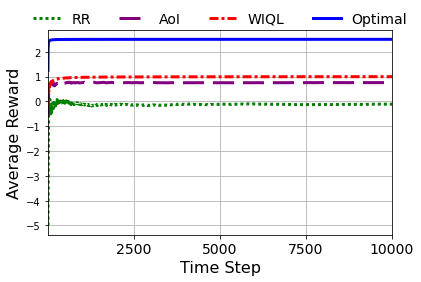

In [30]:
# Re-run the plotting code after execution state reset

import matplotlib.pyplot as plt
import pandas as pd

# Reload cumulative reward data from saved CSV files
cumulative_rewards_wiql = pd.read_csv("cumulative_rewards_WIQL_final.csv")["cumulative_reward"].values
cumulative_rewards_whittle = pd.read_csv("cumulative_rewards_whittle_aoi_final.csv")["cumulative_reward"].values
cumulative_rewards_rr = pd.read_csv("cumulative_rewards_round_robin_final.csv")["cumulative_reward"].values
cumulative_rewards_oracle = pd.read_csv("cumulative_rewards_optimal_final.csv")["cumulative_reward"].values

# Create the figure
plt.figure(figsize=(6, 4))

# Plot cumulative rewards over time with different styles

plt.plot(range(len(cumulative_rewards_rr)), cumulative_rewards_rr, linestyle=(0, (1, 1)), linewidth=3, color='green', label='RR')      # Dotted line
plt.plot(range(len(cumulative_rewards_whittle)), cumulative_rewards_whittle, linestyle=(0, (7, 3)), linewidth=3, color='purple', label='AoI')  # Dashed line
plt.plot(range(len(cumulative_rewards_wiql)), cumulative_rewards_wiql, linestyle=(0, (3, 1, 1, 1)), linewidth=3, color='red', label='WIQL')  # Dash-dot-dot
plt.plot(range(len(cumulative_rewards_oracle)), cumulative_rewards_oracle, linestyle='solid', linewidth=3, color='blue', label='Optimal')  # Solid line


# Set axis labels
plt.xlabel("Time Step", fontsize=16)
plt.ylabel("Average Reward", fontsize=16)

# Adjust legend placement
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=4, fontsize=14, frameon=False)

# Enable grid and adjust layout
plt.grid(True)
plt.tight_layout()

# Set x-axis limits and ticks to display at steps of 5000, 10000, 15000, and 20000
plt.xlim(0, 10000)
plt.xticks([2500, 5000, 7500, 10000], fontsize=14)

# Show the plot
plt.show()


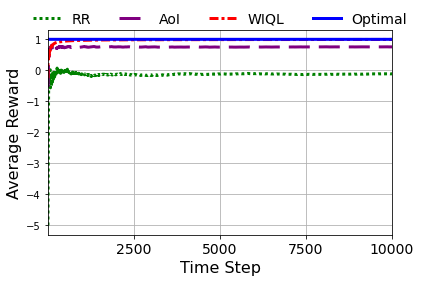

In [31]:
# Re-run the plotting code after execution state reset

import matplotlib.pyplot as plt
import pandas as pd

# Reload cumulative reward data from saved CSV files
cumulative_rewards_wiql = pd.read_csv("cumulative_rewards_WIQL_final.csv")["cumulative_reward"].values
cumulative_rewards_whittle = pd.read_csv("cumulative_rewards_whittle_aoi_final.csv")["cumulative_reward"].values
cumulative_rewards_rr = pd.read_csv("cumulative_rewards_round_robin_final.csv")["cumulative_reward"].values
#cumulative_rewards_oracle = pd.read_csv("cumulative_rewards_optimal_final.csv")["cumulative_reward"].values
cumulative_rewards_oracle = pd.read_csv("cumulative_rewards_oracle_final_2.csv")["cumulative_reward"].values

# Create the figure
plt.figure(figsize=(6, 4))

# Plot cumulative rewards over time with different styles

plt.plot(range(len(cumulative_rewards_rr)), cumulative_rewards_rr, linestyle=(0, (1, 1)), linewidth=3, color='green', label='RR')      # Dotted line
plt.plot(range(len(cumulative_rewards_whittle)), cumulative_rewards_whittle, linestyle=(0, (7, 3)), linewidth=3, color='purple', label='AoI')  # Dashed line
plt.plot(range(len(cumulative_rewards_wiql)), cumulative_rewards_wiql, linestyle=(0, (3, 1, 1, 1)), linewidth=3, color='red', label='WIQL')  # Dash-dot-dot
plt.plot(range(len(cumulative_rewards_oracle)), cumulative_rewards_oracle, linestyle='solid', linewidth=3, color='blue', label='Optimal')  # Solid line


# Set axis labels
plt.xlabel("Time Step", fontsize=16)
plt.ylabel("Average Reward", fontsize=16)

# Adjust legend placement
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=4, fontsize=14, frameon=False)

# Enable grid and adjust layout
plt.grid(True)
plt.tight_layout()

# Set x-axis limits and ticks to display at steps of 5000, 10000, 15000, and 20000
plt.xlim(0, 10000)
plt.xticks([2500, 5000, 7500, 10000], fontsize=14)

# Show the plot
plt.show()
